<a href="https://colab.research.google.com/github/86lekwenshiung/Neural-Network-with-Tensorflow/blob/main/Project_3_Natural_Language_Processing_with_Reddit_Post.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction : Natural Language Processing On Subreddit Posts
___
<p align = 'center'>
  <img src = 'https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/images/marktwain.jpg' width = 75%>
<p/>

`Problem Statement`

With the overflowing of information in the current world , we often find it hard to discern between what is real and fake , what is true and false and what is the full story and selective story. 

- Is it clear what the goal of the project is?
- What type of model will be developed?
- How will success be evaluated?
- Is the scope of the project appropriate?
- Is it clear who cares about this or why this is important to investigate?
- Does the student consider the audience and the primary and secondary stakeholders?

<a id = 'section_0'><a/>
# 0.0 Function Creation
___

In [83]:
# Platform Interface
import time
from time import sleep
import requests
import pickle
import os

import pandas as pd
import numpy as np
import random
import itertools

# Visualisation Libraries
# !pip install --upgrade --quiet witwidget lime
# import lime
# import shap
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud

# ML Libraries
from nltk.tokenize import word_tokenize , sent_tokenize , RegexpTokenizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer , TfidfTransformer , TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix , plot_roc_curve , confusion_matrix , roc_curve
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization 
import tensorflow_hub as hub

!pip3 install --quiet tensorflow-text
import tensorflow_text as text


pd.set_option('display.max_colwidth' , 300)

In [84]:
def red_scrap(title):
    url = 'https://api.pushshift.io/reddit/search/submission'
    df_load = []
    params = {
        'subreddit': title,
        'size' : 100,
        'before': None
    }
    for i in range(15):
        # Access Reddit API
        res = requests.get(url,params)
        data = res.json()
        posts = data['data']
        
        
        df_new = pd.DataFrame(posts)
        df_load.append(df_new)
        
        # Initiating new time stamp (100th position of the 100 size) for before in params
        params['before'] = df_new['created_utc'][99]
        
        # Extract to CSV
        df = pd.concat(df_load, ignore_index = True)
        df.to_csv(f'{title}.csv')
        time.sleep(10)
        print(f'{i+1} Iterations completed')
        
    return df

In [85]:
def date_conversion(df , column):

    time_value = []
    for value in df[column]:
        time_value.append(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(value)))
        
    df[column] = time_value
    df[[column]] = df[[column]].astype('datetime64[ns]')
    return df

In [86]:
def ngram_generator(df , ngram , subreddit = None):
  
  """
  This function contains 2 actions in order to process the word into visualiation base on the ngram count.
  1. CountVectorize & Transform Data
  2. Convert Data back to Matrix
  """
  
  if subreddit == None:
    cvec = CountVectorizer(ngram_range=(ngram,ngram))
    cvec.fit(df['title'])
    transformed = cvec.transform(df['title'])

  if subreddit == 'fake':
    cvec = CountVectorizer(ngram_range = (ngram,ngram))
    cvec.fit(df[df['subreddit'] == 0]['title'])
    transformed = cvec.transform(df[df['subreddit'] == 0]['title'])

  elif subreddit == 'world':
    cvec = CountVectorizer(ngram_range = (ngram,ngram))
    cvec.fit(df[df['subreddit'] == 1]['title'])
    transformed = cvec.transform(df[df['subreddit'] == 1]['title'])

  df_transformed = pd.DataFrame(transformed.todense(),
                                columns = cvec.get_feature_names())
  
  return df_transformed

In [87]:
def ngram_visualizer(df1 , df2 , df3):

  '''
  df1 = Main DF
  df2 = Fakenews
  df3 = Worldnews
  '''
  fig , ax = plt.subplots(1 , 3 , figsize = (24,10))

  df1.sum().sort_values(ascending = True)[-20:].plot(kind = 'bar' , ax = ax[0])
  ax[0].set_title('Trending Words in All Subreddit Post' , fontsize = 14);

  df2.sum().sort_values(ascending = True)[-20:].plot(kind = 'bar' , ax = ax[1] , color = 'lightblue')
  ax[1].set_title('Trending Words in FAKENEWS Subreddit Post' , fontsize = 14);

  df3.sum().sort_values(ascending = True)[-20:].plot(kind = 'bar' , ax = ax[2] , color = 'green')
  ax[2].set_title('Trending Words in WORLDNEWS Subreddit Post' , fontsize = 14);

In [88]:
def eval_classification(y_true , y_pred):

    from sklearn.metrics import accuracy_score , precision_score , recall_score , f1_score

    # Define Scoring variables
    accuracy = accuracy_score(y_true , y_pred)
    precision = precision_score(y_true , y_pred)
    recall = recall_score(y_true , y_pred)
    f1_score = f1_score(y_true , y_pred)

    score_dict = {'Accuracy' : accuracy,
                'Precision' : precision,
                'Recall' : recall,
                'F1 Score' : f1_score}

    return score_dict

In [89]:
import datetime

def create_tensorboard_callback(dir_name , experiment_name):
  log_dir = dir_name +'/' + experiment_name +'/' +datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f'Saving Tensorboard log files to {log_dir}')
  return tensorboard_callback

In [90]:
def tf_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [91]:
def plot_roc_curve_keras(model , X_test , y_test): 

  y_proba = model.predict(X_test).ravel()

  fpr , tpr , thresholds = roc_curve(y_test , y_proba)

  plt.plot(fpr,tpr) 
  plt.plot([[0,0] , [1,1]] , 
         linestyle = '-.',
         label = 'baseline');
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()    

In [92]:
# df_fakenews = red_scrap('fakenews')

In [93]:
# df_worldnews = red_scrap('worldnews')

In [94]:
tf.config.list_physical_devices('GPU')
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



<a id = 'section_1'><a/>
# 1.0 Data Exploration
___
[(back to top)](#content)

In [95]:
!wget https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/fakenews.csv
!wget https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/worldnews.csv

--2021-09-24 10:06:22--  https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/fakenews.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3523846 (3.4M) [text/plain]
Saving to: ‘fakenews.csv.2’

fakenews.csv.2      100%[===================>]   3.36M  --.-KB/s    in 0.02s   

2021-09-24 10:06:22 (152 MB/s) - ‘fakenews.csv.2’ saved [3523846/3523846]

--2021-09-24 10:06:23--  https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/worldnews.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP re

In [96]:
# Fake News Reddit
df_fakenews = pd.read_csv('/content/fakenews.csv')
df_fakenews = df_fakenews[['title' , 'subreddit' , 'created_utc']]
df_fakenews = date_conversion(df_fakenews , 'created_utc')

# World News Reddit
df_worldnews = pd.read_csv('/content/worldnews.csv')
df_worldnews = df_worldnews[['title' , 'subreddit' , 'created_utc']]
df_worldnews = date_conversion(df_worldnews , 'created_utc')

In [97]:
print(f'No. of Fakenews Datasets : {len(df_fakenews)}')
print(f'Shape of Fakenews Datasets : {df_fakenews.shape}')

print(f'No. of World News Datasets : {len(df_worldnews)}')
print(f'Shape of World News Datasets : {df_worldnews.shape}')

No. of Fakenews Datasets : 1500
Shape of Fakenews Datasets : (1500, 3)
No. of World News Datasets : 1400
Shape of World News Datasets : (1400, 3)


### 1.1 Checking for Duplicates and Null
___

In [98]:
print(f'No. of Duplicate Cell : {df_fakenews.duplicated().sum()}')
print(f'No. of Null Cell : {df_fakenews.isnull().sum().sum()}')
df_fakenews.drop_duplicates(inplace = True)
print(f'No. of Duplicate Cell After Remove Duplicate : {df_fakenews.duplicated().sum()}')

No. of Duplicate Cell : 1
No. of Null Cell : 0
No. of Duplicate Cell After Remove Duplicate : 0


In [99]:
print(f'No. of Duplicate Cell : {df_worldnews.duplicated().sum()}')
print(f'No. of Null Cell : {df_worldnews.isnull().sum().sum()}')

No. of Duplicate Cell : 0
No. of Null Cell : 0


### 1.2 Visualing Some Random Text
___

In [100]:
# Visualing Some Random Post from Fake News
random_sentences = random.sample(df_fakenews['title'].to_list() , 10)
for index , sentence in enumerate(random_sentences):
    print(index , sentence)

0 One day of fewer hospitalizations does not make a "trend", especially not when it's less than a 1% decrease...
1 Trump supporters “significantly” more likely to believe AI generated fake news is genuine according to experiment.
2 India based fact checker took down report that concluded rising hate crimes against Muslims, after ridiculous amount of Hindu victims found to be purposefully left out. The report was cited in every reputable newspaper btw.
3 the foto of this chinese guy in the news of msnbc / FBI Timestamp 12:31
4 Our rights
5 💜❤️🖤 Lewd Chat
6 Hmm. wth? 43,44,46 pretty sure that's not how it goes.
7 Is this true? I want it to be but I'm sceptical
8 I got ya homie!
9 Dubio - community-driven platform for debunking false claims - looking for front-end developer!


In [101]:
# Visualing Some Random Post from World News
random_sentences = random.sample(df_worldnews['title'].to_list() , 10)
for index , sentence in enumerate(random_sentences):
    print(index , sentence)

0 槍口下的示威？皮開肉綻的阿富汗記者與「喀布爾女子抗爭」 – UDN 聯合新聞網
1 Revealed: Google illegally underpaid thousands of workers across dozens of countries
2 Lululemon Says Sales Soar But Supply Chain Remains a Concern
3 US says Taliban 'businesslike and professional' in Afghan evacuation
4 North Korea suspended from IOC until end of 2022
5 India Role As Regional Ally Can Have Positive Impact In Afghanistan: US Official
6 Olaf weakens after hitting Mexico's Los Cabos as Cat 2 storm
7 Bir qadın üçün ideal kişi necə olmalıdır? - 15 bəndlik istək ￼
8 The next flu pandemic: a matter of ‘when’, not ‘if’
9 Any Video Converter Ultimate Crack v7.2.0 Serial Key [2021]


# 2.0 Data Cleaning and Preprocessing
___

In [102]:
import nltk
import string
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

port_stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 2.1 TextVectorizer Input and Visualize Random Sentence
___

In [103]:
'''
1. Standardize each example (usually lowercasing + punctuation stripping)
2. Split each example into substrings (usually words)
3. Recombine substrings into tokens (usually ngrams)
'''
random_sentences = random.sample(df_fakenews['title'].to_list() , 3)

for sentence in random_sentences:
    
    # Print Before Split
    print('Original Sentence                : ' , sentence)

    # Remove Numeric Number , lower words
    regex_token = RegexpTokenizer(r'[a-zA-Z]\w+')
    sent_split = regex_token.tokenize(sentence.lower())
    print('Remove Numeric , lowercase       : ' , sent_split)
    
    # Stripped the Punctuation
    sent_split = [word for word in sent_split if word not in (string.punctuation)]
    print('Remove Punctuation               : ' , sent_split)

    # Remove Stop words
    sent_split = [word for word in sent_split if word not in (stop_words)]
    print('Remove Stop words                : ' , sent_split)

    # Stem the words and joint back  
    joint = ' '.join([port_stemmer.stem(word) for word in sent_split])
    print('Stem the words & joint the words : ' , joint)
    print('-----------------------------------------')
    

Original Sentence                :  Speaker Pelosi Visits SF's Chinatown To Show Support Amid Coronavirus Fears
Remove Numeric , lowercase       :  ['speaker', 'pelosi', 'visits', 'sf', 'chinatown', 'to', 'show', 'support', 'amid', 'coronavirus', 'fears']
Remove Punctuation               :  ['speaker', 'pelosi', 'visits', 'sf', 'chinatown', 'to', 'show', 'support', 'amid', 'coronavirus', 'fears']
Remove Stop words                :  ['speaker', 'pelosi', 'visits', 'sf', 'chinatown', 'show', 'support', 'amid', 'coronavirus', 'fears']
Stem the words & joint the words :  speaker pelosi visit sf chinatown show support amid coronaviru fear
-----------------------------------------
Original Sentence                :  Great New Video 💥 Globalist Bankster Admits (COVID-19 Has Been In The Works For 40 Years) 💥
Remove Numeric , lowercase       :  ['great', 'new', 'video', 'globalist', 'bankster', 'admits', 'covid', 'has', 'been', 'in', 'the', 'works', 'for', 'years']
Remove Punctuation           

### 2.2 Preprocess Function for data
___

In [104]:
def preprocessing(df , col):
    
    sentence_process = []
    for sentence in df[col]:
               
        # Remove Numeric Number , lower words
        regex_token = RegexpTokenizer(r'[a-zA-Z]\w+')
        sent_split = regex_token.tokenize(sentence.lower())
        
        # Stripped the Punctuation
        sent_split = [word for word in sent_split if word not in (string.punctuation)]

        # Remove Stop words
        sent_split = [word for word in sent_split if word not in (stop_words)]

        # Stem the words and joint back  
        joint = ' '.join([port_stemmer.stem(word) for word in sent_split])        
    
        sentence_process.append(joint)
    
    df[col] = sentence_process

In [105]:
preprocessing(df_fakenews , 'title')

In [106]:
df_fakenews.head()

,title,subreddit,created_utc
0,research show great awoken media preced trump outlast opinion,fakenews,2021-09-11 13:37:46
1,get paid china stir panic,fakenews,2021-09-10 18:52:00
2,fact check journalist spread misinform wi spa,fakenews,2021-09-10 16:25:26
3,afghani central bank governor imag goe viral real asia market,fakenews,2021-09-10 13:48:40
4,stori mike emm real,fakenews,2021-09-08 21:29:04


In [107]:
preprocessing(df_worldnews , 'title')

In [108]:
df_worldnews.head()

,title,subreddit,created_utc
0,mari trump say disgrac uncl spend comment box match,worldnews,2021-09-12 06:20:04
1,next fast food chicken sandwich war may fake one,worldnews,2021-09-12 06:11:44
2,revis belgium histori call first ebola outbreak congo,worldnews,2021-09-12 06:00:46
3,democrat build big edg earli vote,worldnews,2021-09-12 05:59:43
4,ch51 ch51,worldnews,2021-09-12 05:59:42


### 2.3 Merging Datasets
___

In [109]:
df_main = pd.concat([df_fakenews , df_worldnews])
df_main.drop('created_utc' , inplace=True , axis = 1)

print(f'No. of Combined Datasets : {len(df_main)}')
print(f'Shape of Combined Datasets : {df_main.shape}')
print(f'SIze of Combined Datasets : {df_main.size}')

No. of Combined Datasets : 2899
Shape of Combined Datasets : (2899, 2)
SIze of Combined Datasets : 5798


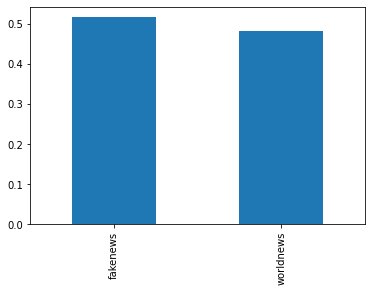

In [110]:
df_main['subreddit'].value_counts(normalize = True).plot(kind = 'bar');

In [111]:
dict_reddit = {'fakenews' : 0,
               'worldnews' : 1}

df_main['subreddit'] = df_main['subreddit'].map(dict_reddit)

### 2.4 Removing Sentence with less than 2 word
___

In [112]:
df_main['len of sentence'] = [len(sentence.split(' ')) for sentence in df_main['title']]

In [113]:
print('No. of Sentence with 1 word :' , len(df_main[df_main['len of sentence'] == 1]))
print('Longest Sentence :' , df_main['len of sentence'].max())
df_main[df_main['len of sentence'] == 1].head(10)

No. of Sentence with 1 word : 140
Longest Sentence : 46


,title,subreddit,len of sentence
11,,0,1
31,hhhmmm,0,1
40,propaganda,0,1
58,reddit,0,1
116,guid,0,1
157,make,0,1
166,cnn,0,1
193,,0,1
220,real,0,1
245,world,0,1


In [114]:
df_main = df_main[df_main['len of sentence'] > 2]

In [115]:
# !pip install unidecode
# import unidecode

### 2.5 Visualising Popular Words
___

In [116]:
# Inistantiating Count Vectorizer
cvec = CountVectorizer(ngram_range=(1,3))
cvec.fit(df_main['title'])
main = cvec.transform(df_main['title'])

cvec_fake = CountVectorizer(ngram_range = (1,3))
cvec_fake.fit(df_main[df_main['subreddit'] == 0]['title'])
fake = cvec_fake.transform(df_main[df_main['subreddit'] == 0]['title'])

cvec_world = CountVectorizer(ngram_range = (1,3))
cvec_world.fit(df_main[df_main['subreddit'] == 1]['title'])
world = cvec_world.transform(df_main[df_main['subreddit'] == 1]['title'])

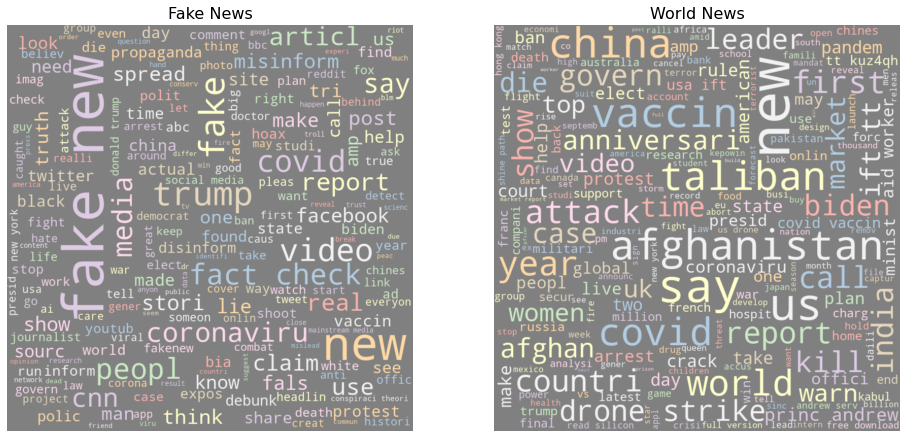

In [117]:
# Word cloud for news

word_fake = ' '.join([word for word in df_main[df_main['subreddit'] == 0]['title']])
word_world = ' '.join([word for word in df_main[df_main['subreddit'] == 1]['title']])

wordcloud_fake = WordCloud(width= 800, 
                          height= 800,
                          max_font_size = 110,
                          collocations = True,
                          background_color = 'grey',
                          colormap= 'Pastel1').generate(word_fake)

wordcloud_world = WordCloud(width= 800, 
                            height= 800,
                            max_font_size = 110,
                            collocations = True,
                            background_color = 'grey',
                            colormap= 'Pastel1').generate(word_world)                      

plt.figure(figsize=(16,12))
plt.subplot(1,2,1)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis("off")
plt.title('Fake News' , fontsize = 16)

plt.subplot(1,2,2)
plt.imshow(wordcloud_world, interpolation='bilinear')
plt.axis("off")
plt.title('World News' , fontsize = 16);

In [118]:
# Interestingly the vocab from each DF summed up is not equal to the vocab from the merged DF
df_main_vocab = pd.DataFrame(main.todense(),
                             columns = cvec.get_feature_names())

df_fake_vocab = pd.DataFrame(fake.todense(),
                             columns = cvec_fake.get_feature_names())

df_world_vocab = pd.DataFrame(world.todense(),
                              columns = cvec_world.get_feature_names())

print(f'DF Shape for Main Vocab :' , df_main_vocab.shape)
print(f'DF Shape for fakenews Vocab  :' , df_fake_vocab.shape)
print(f'DF Shape for worldnews Vocab  :' , df_world_vocab.shape)

DF Shape for Main Vocab : (2605, 38597)
DF Shape for fakenews Vocab  : (1293, 19458)
DF Shape for worldnews Vocab  : (1312, 20943)


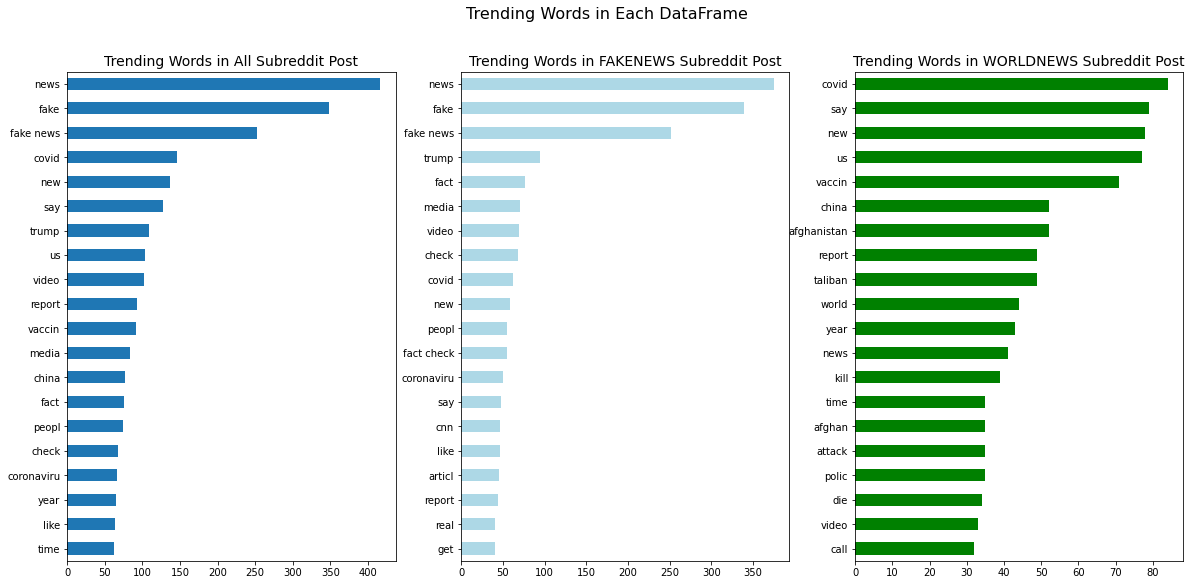

In [119]:
fig , ax = plt.subplots(1 , 3 , figsize = (20,9))

df_main_vocab.sum().sort_values(ascending = True)[-20:].plot(kind = 'barh' , ax = ax[0])
ax[0].set_title('Trending Words in All Subreddit Post' , fontsize = 14);

df_fake_vocab.sum().sort_values(ascending = True)[-20:].plot(kind = 'barh' , ax = ax[1] , color = 'lightblue')
ax[1].set_title('Trending Words in FAKENEWS Subreddit Post' , fontsize = 14);

df_world_vocab.sum().sort_values(ascending = True)[-20:].plot(kind = 'barh' , ax = ax[2] , color = 'green')
ax[2].set_title('Trending Words in WORLDNEWS Subreddit Post' , fontsize = 14);

plt.suptitle('Trending Words in Each DataFrame' , fontsize = 16);

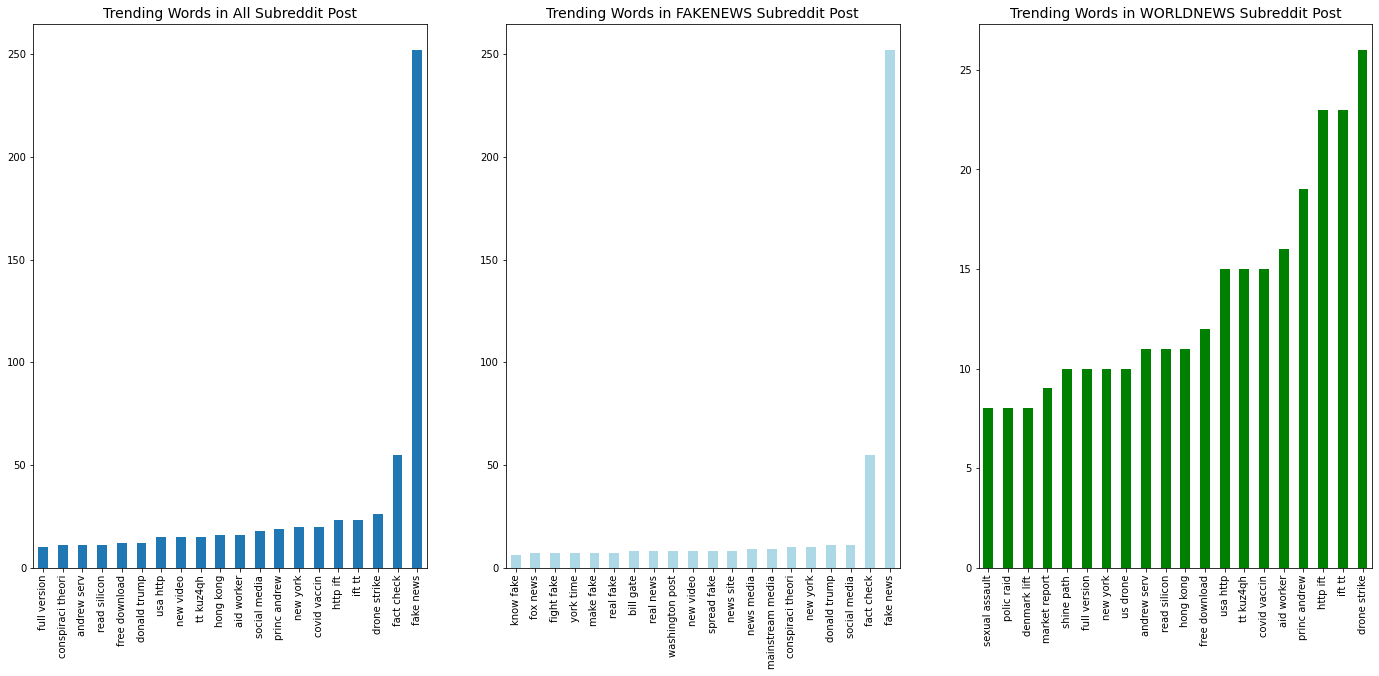

In [120]:
df_main_vocab_n2 = ngram_generator(df_main , 2)
df_world_vocab_n2 = ngram_generator(df_main , 2 , 'world')
df_fake_vocab_n2 = ngram_generator(df_main , 2 , 'fake')

ngram_visualizer(df_main_vocab_n2 , df_fake_vocab_n2 , df_world_vocab_n2)

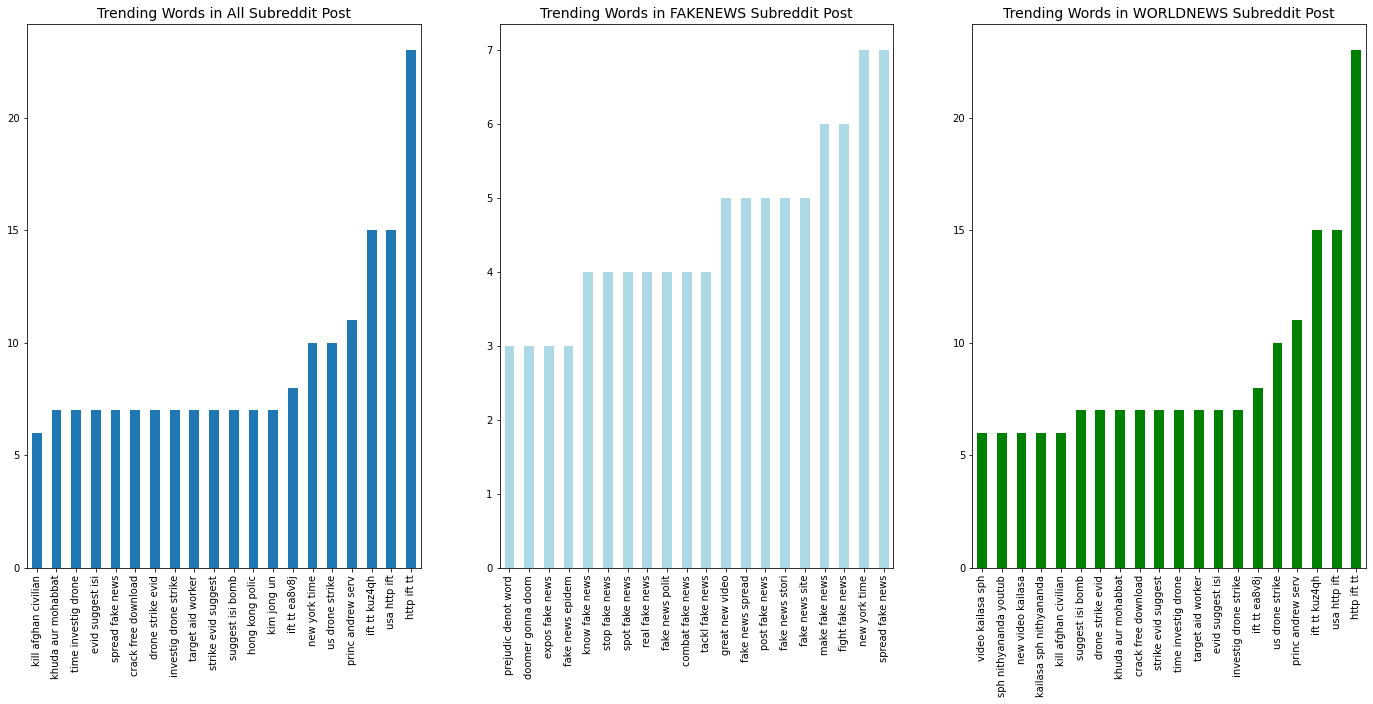

In [121]:
df_main_vocab_n3 = ngram_generator(df_main , 3)
df_world_vocab_n3 = ngram_generator(df_main , 3 , 'world')
df_fake_vocab_n3 = ngram_generator(df_main , 3 , 'fake')

ngram_visualizer(df_main_vocab_n3 , df_fake_vocab_n3 , df_world_vocab_n3)

### 2.6 Removing Data Leakage
___

In [122]:
# DF Fake News
print('Data Count Before removal leaked words:' , len(df_main))
df_main = df_main.loc[~df_main['title'].str.contains('fake|news|new|say|http|ift|https')]
df_main.head()
print('Data Count After removal leaked words:' , len(df_main))

Data Count Before removal leaked words: 2605
Data Count After removal leaked words: 1847


### 2.7 Splitting Data
___

In [123]:
X = df_main['title']
y = df_main['subreddit']

X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.2 ,random_state=42 , stratify = y)

print('X_train Shape : ' , X_train.shape)
print('X_test Shape : ' , X_test.shape)
print('y_train Shape : '  , y_train.shape)
print('y_test Shape : ' , y_test.shape)

X_train Shape :  (1477,)
X_test Shape :  (370,)
y_train Shape :  (1477,)
y_test Shape :  (370,)


### 2.8 Checking for Data Imbalance
___

After removing leaked words and aplitting the dataset , the dataset between Fakenews and World News is quite evenly split between Fake and World News at 42% to 57%. We will not smote the dataset in this run.

In [124]:
# We Have Imbalance Data , need to SMOTE before that.
print(f' Fake News % : {y.value_counts(normalize=True)[0]*100}')
print(f' World News % : {y.value_counts(normalize=True)[1]*100}')

 Fake News % : 42.230644288034654
 World News % : 57.76935571196535


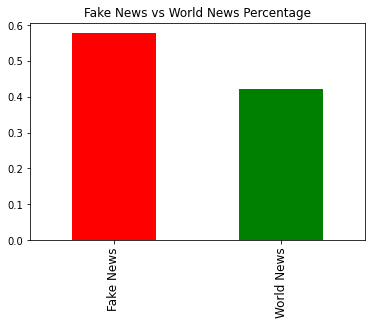

In [125]:
ax = y.value_counts(normalize=True).plot(kind = 'bar' , color = ['red' , 'green'])
ax.set_xticklabels(['Fake News' , 'World News'],fontsize=12);
ax.set_title('Fake News vs World News Percentage');

#3.0 Modelling with Random Forest

In [126]:
# %%time
# pipe = Pipeline([('vect', CountVectorizer()),
#                  ('tfidf', TfidfTransformer()),
#                  ('model', RandomForestClassifier())
# ])

# # rf_param_grid = {'min_samples_split' : np.arange(2 , 10 , 2),
# #                  'min_samples_leaf' : np.arange(1, 5 , 1),
# #                  'n_estimators' : np.arange(50 , 80 , 10),
# #                  'max_features' : ['log2' , 'sqrt' , 'auto'],
# #                  'max_depth' : [None , 3 , 5]}

# param_grid = {'vect__ngram_range' : [(1,1) , (1,2) , (1,3)],
#               'tfidf__smooth_idf' : [True , False],
#               'tfidf__sublinear_tf' : [True , False],
#               'model__min_samples_split' : np.arange(2 , 10 , 2),
#               'model__min_samples_leaf' : np.arange(1 , 5 , 1),
#               'model__n_estimators' : np.arange(50 , 80 , 10),
#               'model__max_features' : ['log2' , 'sqrt' , 'auto'],
#               'model__max_depth' : [3,5,7]              
# }

# # Fitting the model
# model = GridSearchCV(estimator = pipe,
#                      param_grid = param_grid,
#                      cv = 5,
#                      n_jobs =-1)

# model.fit(X_train , y_train)
# # # Model Prediction
# y_pred = model.predict(X_test)

In [127]:
# model.best_params_

In [128]:
# # Saving the Model
# pickle.dump(model , open('RFC_model.pkl' , 'wb'))

In [129]:
# !wget https://github.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/blob/main/saved_models/RFC_model.pkl

### 3.1 Fine Tuning Grid Search Parameter
___

In [130]:
# %%time
# pipe = Pipeline([('vect', CountVectorizer()),
#                  ('tfidf', TfidfTransformer()),
#                  ('model', RandomForestClassifier())
# ])

# # rf_param_grid = {'min_samples_split' : np.arange(2 , 10 , 2),
# #                  'min_samples_leaf' : np.arange(1, 5 , 1),
# #                  'n_estimators' : np.arange(50 , 80 , 10),
# #                  'max_features' : ['log2' , 'sqrt' , 'auto'],
# #                  'max_depth' : [None , 3 , 5]}

# param_grid = {'vect__min_df' : range(5,10),
#               'vect__max_df' : np.arange(0.90 , 1.0 , 0.1),
#               'model__min_samples_split' : np.arange(1 , 5 , 1),
#               'model__min_samples_leaf' : np.arange(6 , 8 , 1),
#               'model__n_estimators' : np.arange(90 , 120 , 10),
#               'model__max_features' : ['sqrt'],
#               'model__max_depth' : [None]              
# }

# # Fitting the model
# model_2 = GridSearchCV(estimator = pipe,
#                        param_grid = param_grid,
#                        cv = 5,
#                        n_jobs =-1)

# model_2.fit(X_train , y_train)
# # # Model Prediction
# y_pred_2 = model_2.predict(X_test)

In [131]:
# model_2.best_params_

In [132]:
model_RFC = Pipeline([('vect', CountVectorizer(min_df = 5 , max_df = 0.90 , ngram_range = (1,1))),
                      ('tfidf', TfidfTransformer('l2')),
                      ('model', RandomForestClassifier(min_samples_split= 3,
                                                       min_samples_leaf = 6,
                                                       n_estimators = 110,
                                                       max_features = 'sqrt'))
])


model_RFC.fit(X_train , y_train)
model_RFC_pred = model_RFC.predict(X_test)

### 3.2 Evaluating Random Forest Classifier Model Score
___

{'Accuracy': 0.7783783783783784,
 'F1 Score': 0.8305785123966943,
 'Precision': 0.7444444444444445,
 'Recall': 0.9392523364485982}

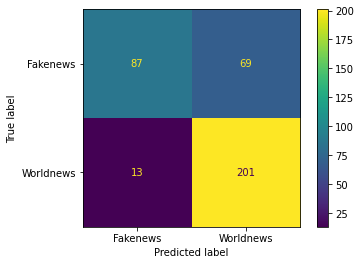

In [133]:
plot_confusion_matrix(model_RFC , X_test , 
                      y_test , 
                      values_format = '.4g',
                      display_labels = ['Fakenews' , 'Worldnews']);

rfc_score = eval_classification(y_true=y_test , y_pred = model_RFC_pred)
rfc_score

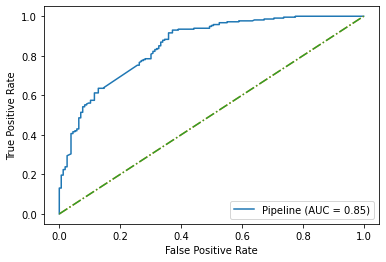

In [134]:
rfc_plot = plot_roc_curve(model_RFC , X_test , y_test)
plt.plot([[0,0] , [1,1]] , 
         linestyle = '-.',
         label = 'baseline');

### 3.3 Visualing Most Wrongly Predicted Reddit Post
___

In [135]:
y_proba = model_RFC.predict_proba(X_test)
fakenews_prediction = [y_proba[i][0] for i in range(len(X_test))]
worldnews_prediction = [y_proba[i][1] for i in range(len(X_test))]

In [136]:
df_prediction  = pd.DataFrame({'Title' : X_test,
                              'Target' : y_test,
                              'Prediction' : model_RFC_pred,
                              'Fakenews_score' : fakenews_prediction,
                              'Worldnews_score' : worldnews_prediction})

In [137]:
# Visualing Most Wrong World News

df_most_right_wrong = df_prediction[df_prediction['Target'] != df_prediction['Prediction']].sort_values(by = 'Fakenews_score' , ascending = False).drop('Worldnews_score' , axis = 1)
df_most_right_wrong.head(10)

,Title,Target,Prediction,Fakenews_score
1398,trump gripe lose ungrat cathol jewish voter call religi advis,1,0,0.755227
1123,girl rescu famili tri goug eye cannibalist black magic ritual coconut jakarta,1,0,0.727022
1069,pakistan report fresh coronaviru case death,1,0,0.713501
1346,facebook apolog put primat label video black men,1,0,0.700368
10,ben affleck push intrus fan tri click selfi jennif lopez venic airport,1,0,0.667825
872,orfium project offic elstudio,1,0,0.608769
710,btc giveaway promot like page comment btc address,1,0,0.577175
1012,lebanon govern announc friday pm design tell local media,1,0,0.564569
804,watch babycharlotte_99 twitter babychar viral video babychar17 trend twitter page explor,1,0,0.564313
568,happen gener facebook websit xml sitemap file,1,0,0.550054


In [138]:
# Visualing Most Wrong fake News

df_most_right_wrong = df_prediction[df_prediction['Target'] != df_prediction['Prediction']].sort_values(by = 'Worldnews_score' , ascending = False).drop('Fakenews_score' , axis = 1)
df_most_right_wrong.head(10)

,Title,Target,Prediction,Worldnews_score
261,pocahonta first winner hunger game,0,1,0.808074
74,afghan ambassador daughter bruis blood mark real,0,1,0.777056
1486,misconcept cast system india,0,1,0.764635
373,due covid travel restrict american forc hold coup local year,0,1,0.754556
405,zombi fliegen dänemark entdeckt soll ja bald auch auf den menschen bertragbar sein wobei der pilz dann wohl nicht die genitalien de wirt frisst sondern sein gehirn können all querdenk und coronaleugn aufatmen,0,1,0.736116
1330,thai seal murder cave rescu cover last year,0,1,0.736045
1085,wonder solut could,0,1,0.694649
32,one day fewer hospit make trend especi less decreas,0,1,0.691698
751,polic seiz rifl st loui coupl film wave gun blm protest,0,1,0.688035
1450,man best friend shot woman,0,1,0.685445


# 4.0 Modelling with LSTM
___

### 4.1 Creating LSTM Model
___

1. Create a Text Vectorizer layer
  * TF had an in built text vectorizer layer which preprocess the sentences. This include removing case , lowering letter and parameters to set no. of words in our vocab and sentence.
2. Create an embedding layer.
  * This create a layer where it convert the tokens into word vectors.
3. Create LSTM layers and Hidden layers.
4. Create output layer with 1 output.  

In [139]:
max_vocab_length = 120  # Max number of words in our vocab
max_length = 30 # max length our sequence will be (In this case the sequence is a tweet)

text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                    output_mode = 'int',
                                    output_sequence_length = max_length,
                                    pad_to_max_tokens = True)

text_vectorizer.adapt(X_train) # so your text vectorization will create a vocab.


embedding = tf.keras.layers.Embedding(input_dim = max_vocab_length,
                                      output_dim = 128,
                                      input_length = max_length,
                                      name = 'embedding')

inputs = layers.Input(shape = (1,) , dtype = tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
x = layers.Bidirectional(layers.LSTM(64 , return_sequences = True))(x)
print(x.shape)
x = layers.Bidirectional(layers.LSTM(32))(x)
print(x.shape)
outputs = layers.Dense(1 , activation = 'sigmoid')(x)
print(x.shape)

model_lstm = tf.keras.Model(inputs , outputs , name = 'lstm_bidrection')

(None, 30, 128)
(None, 30, 128)
(None, 64)
(None, 64)


In [140]:
model_lstm.summary()

Model: "lstm_bidrection"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_2 (TextVe (None, 30)                0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 128)           15360     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 30, 128)           98816     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 155,457
Trainable params: 155,457
Non-trainable params: 0
_____________________________________________

In [190]:
model_lstm.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.01),
                   loss = tf.keras.losses.BinaryCrossentropy(),
                   metrics = 'accuracy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [191]:
history_lstm = model_lstm.fit(X_train,
                              y_train,
                              epochs = 20,
                              validation_data = (X_test , y_test),
                              callbacks = [create_tensorboard_callback('model_log' , 'lstm_model')])

Saving Tensorboard log files to model_log/lstm_model/20210924-102942
Epoch 1/20
47/47 [==============================] - 14s 149ms/step - loss: 0.8337 - accuracy: 0.6114 - val_loss: 0.6125 - val_accuracy: 0.6973
Epoch 2/20
47/47 [==============================] - 4s 80ms/step - loss: 0.5631 - accuracy: 0.7143 - val_loss: 0.5113 - val_accuracy: 0.7649
Epoch 3/20
47/47 [==============================] - 4s 82ms/step - loss: 0.5093 - accuracy: 0.7651 - val_loss: 0.5138 - val_accuracy: 0.7486
Epoch 4/20
47/47 [==============================] - 4s 81ms/step - loss: 0.4707 - accuracy: 0.7806 - val_loss: 0.4862 - val_accuracy: 0.7892
Epoch 5/20
47/47 [==============================] - 4s 80ms/step - loss: 0.4575 - accuracy: 0.7854 - val_loss: 0.4685 - val_accuracy: 0.7892
Epoch 6/20
47/47 [==============================] - 4s 80ms/step - loss: 0.4311 - accuracy: 0.8077 - val_loss: 0.4737 - val_accuracy: 0.7919
Epoch 7/20
47/47 [==============================] - 4s 81ms/step - loss: 0.4135 - a

In [179]:
model_lstm_pred = model_lstm.predict(X_test)

### 4.2 Evaluating LSTM Model Score
___

In [188]:
lstm_score = eval_classification(y_test , tf.squeeze(tf.round(model_lstm_pred)))
lstm_score

{'Accuracy': 0.7783783783783784,
 'F1 Score': 0.8110599078341014,
 'Precision': 0.8,
 'Recall': 0.822429906542056}

Confusion matrix, without normalization
[[112  44]
 [ 38 176]]


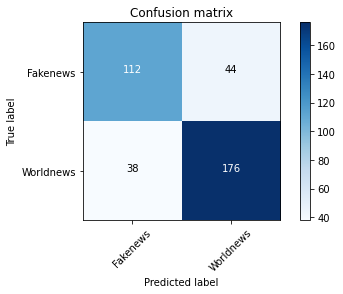

In [189]:
cm = confusion_matrix(y_test , tf.squeeze(tf.round(model_lstm_pred)))

tf_confusion_matrix(cm = cm , classes=['Fakenews' , 'Worldnews']);

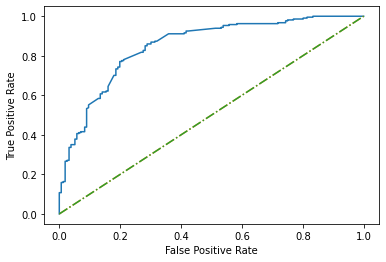

In [146]:
lstm_plot = plot_roc_curve_keras(model_lstm , X_test , y_test)

### 4.3 Visualising Most Wrong Predicted Reddit Post
___

In [147]:
y_proba = model_lstm.predict(X_test)
fakenews_prediction = [y_proba[i][0] for i in range(len(X_test))]

In [148]:
df_prediction_lstm  = pd.DataFrame({'Title' : X_test,
                                  'Target' : y_test,
                                  'Prediction' : tf.squeeze(tf.round(model_lstm_pred)),
                                  'Prediction_score' : fakenews_prediction})

In [149]:
# Visualing Most Wrong World News (LSTM Model)
# Note Prediction Score refer to the model predicting either 0 or 1, While Fakenews Score or worldnews score predict whether it is Fakenews or Worldnews

df_most_right_wrong_lstm = df_prediction_lstm[df_prediction_lstm['Target'] != df_prediction_lstm['Prediction']].sort_values(by = 'Prediction_score' , ascending = False)
df_most_right_wrong_lstm.tail(10)

,Title,Target,Prediction,Prediction_score
713,us post gener critic america patriot opinion,1,0.0,0.201397
10,ben affleck push intrus fan tri click selfi jennif lopez venic airport,1,0.0,0.166465
568,happen gener facebook websit xml sitemap file,1,0.0,0.073769
1398,trump gripe lose ungrat cathol jewish voter call religi advis,1,0.0,0.063826
1000,case regist asaduddin owaisi hate speech,1,0.0,0.062440
872,orfium project offic elstudio,1,0.0,0.057999
1123,girl rescu famili tri goug eye cannibalist black magic ritual coconut jakarta,1,0.0,0.054130
1051,daili covid case like soon exceed next week crucial singapor,1,0.0,0.046358
1069,pakistan report fresh coronaviru case death,1,0.0,0.044159
1346,facebook apolog put primat label video black men,1,0.0,0.040111


In [150]:
# Visualing Most Wrong Fake News (LSTM Model)
df_most_right_wrong_lstm.head(10)

,Title,Target,Prediction,Prediction_score
74,afghan ambassador daughter bruis blood mark real,0,1.0,0.970157
32,one day fewer hospit make trend especi less decreas,0,1.0,0.956854
751,polic seiz rifl st loui coupl film wave gun blm protest,0,1.0,0.956527
261,pocahonta first winner hunger game,0,1.0,0.914793
814,polic vs hypocrisi polic offic could face death penalti shoot rayshard brook,0,1.0,0.909591
780,instagram girl accus cv la habra falsifi covid result,0,1.0,0.866840
1330,thai seal murder cave rescu cover last year,0,1.0,0.847576
377,joe biden chang look pleas oppos,0,1.0,0.847457
1389,know truth histori propaganda pleas see comment section,0,1.0,0.833957
1260,gayl soldier bedroom kobe attest day kobe come back way miss press,0,1.0,0.817720


### 4.4 Visualing Word Embedding
___

In [151]:
# Get the weight matrix of embedding layer
# (these are the numerical representation of each token in our training data)
# For every unique token or vocab , there is 128 vectors representing it.
words_in_vocab = text_vectorizer.get_vocabulary()
embed_weights = model_lstm.get_layer('embedding').get_weights()[0]
embed_weights.shape

(120, 128)

In [152]:
# # Create a checkpoint from embedding, the filename and key are the
# # name of the tensor.
# log_dir = '/content/sample_data/'
# weights = tf.Variable(lstm_model.get_layer('embedding').get_weights()[0][1:])

# checkpoint = tf.train.Checkpoint(embedding=weights)
# checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

In [153]:
# Code below is adapted from: https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk
import io

# Create output writers
out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# Write embedding vectors and words to file
for num, word in enumerate(words_in_vocab):
  if num == 0: 
     continue # skip padding token
  vec = embed_weights[num]
  out_m.write(word + "\n") # write words to file
  out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
out_v.close()
out_m.close()

# Download files locally to upload to Embedding Projector
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download("embedding_vectors.tsv")
  files.download("embedding_metadata.tsv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### 4.4.1 Embedding Projector for 120 Vocab for World and Fake News
___

* The explained variance for this clustering is around 45% , using a vocab limit of 120.
* The vocabs are more representative for our current quantity of data , which is around 2000 sentences.
* 2 clear distinct cluster could be observed : Trump on the fakenews side , and Afghanistan on the worldnews Side

<img src = 'https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/images/fakenews_120vocab.PNG' width = 100%>

<img src = 'https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/images/worldnews_120vocab.PNG' width = 100%>

#### 4.4.2 Embedding Projector for 6000 Vocab for World and Fake News
___

* The explained variance for this clustering is around 22% , using a vocab limit of 6000.
* The vocabs are less representative for our current quantity of data , which is around 2000 sentences. The Vocab are more diluted across a smaller dataset , thus a lower explained variance observed.
* 2 clear distinct cluster could be observed : CNN on the fakenews side , and Afghanistan on the worldnews Side

<img src = 'https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/images/fakenews_6000vocab.PNG' width = 100%>

<img src = 'https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/images/worldnews_6000vocab.PNG' width = 100%>

# 5.0 Modelling with Tensorflow Universal Sentence Encoder
___

### 5.2 Evaluating Universal Sentence Encoder Score
___

In [154]:
max_vocab_length = 120 # We have around 4848 from above visualisation
max_length = 30

text_vectorisation = TextVectorization(max_tokens = max_vocab_length,
                                       output_mode = 'int',
                                       output_sequence_length = None,
                                       pad_to_max_tokens = True)

In [155]:
# random_sentences = random.sample(df_main['title'].to_list() , 3)

# for sentence in random_sentences:
#   print(sentence)
#   print(embed([sentence]))
#   print('------------------------------------------------')

In [156]:
# Create a Keras Layer using Universal Sentence Encoder
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape = [],
                                        dtype = tf.string,
                                        trainable = False,
                                        name = 'tf_model')

In [173]:
model_use = tf.keras.Sequential([
                               sentence_encoder_layer,
                               layers.Dense(64 , activation = 'relu'),
                               layers.Dense(1 , activation = 'sigmoid')
])

model_use.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
                 loss = tf.keras.losses.BinaryCrossentropy(),
                 metrics = 'accuracy')

In [174]:
model_use.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tf_model (KerasLayer)        (None, 512)               256797824 
_________________________________________________________________
dense_14 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [176]:
history_tf = model_use.fit(X_train,
                         y_train,
                         epochs = 20,
                         validation_data = (X_test , y_test),
                         callbacks = [create_tensorboard_callback('model_log' , 'use_model')])

Saving Tensorboard log files to model_log/use_model/20210924-101434
Epoch 1/20
47/47 [==============================] - 1s 24ms/step - loss: 0.5480 - accuracy: 0.7901 - val_loss: 0.5383 - val_accuracy: 0.8108
Epoch 2/20
47/47 [==============================] - 1s 14ms/step - loss: 0.5347 - accuracy: 0.8023 - val_loss: 0.5254 - val_accuracy: 0.8162
Epoch 3/20
47/47 [==============================] - 1s 14ms/step - loss: 0.5222 - accuracy: 0.8030 - val_loss: 0.5133 - val_accuracy: 0.8216
Epoch 4/20
47/47 [==============================] - 1s 14ms/step - loss: 0.5105 - accuracy: 0.8023 - val_loss: 0.5027 - val_accuracy: 0.8243
Epoch 5/20
47/47 [==============================] - 1s 14ms/step - loss: 0.5001 - accuracy: 0.8030 - val_loss: 0.4931 - val_accuracy: 0.8297
Epoch 6/20
47/47 [==============================] - 1s 14ms/step - loss: 0.4905 - accuracy: 0.8104 - val_loss: 0.4852 - val_accuracy: 0.8270
Epoch 7/20
47/47 [==============================] - 1s 15ms/step - loss: 0.4817 - accu

In [160]:
model_use_pred = model_use.predict(X_test)

In [161]:
use_score = eval_classification(y_test , tf.squeeze(tf.round(model_use_pred)))
use_score

{'Accuracy': 0.8162162162162162,
 'F1 Score': 0.8447488584474886,
 'Precision': 0.8258928571428571,
 'Recall': 0.8644859813084113}

Confusion matrix, without normalization
[[117  39]
 [ 29 185]]


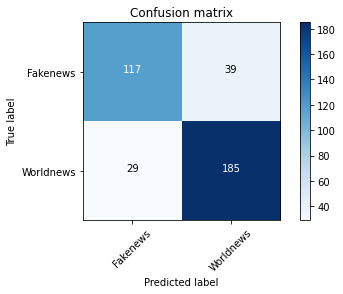

In [162]:
cm = confusion_matrix(y_test , tf.squeeze(tf.round(model_use_pred)))

tf_confusion_matrix(cm = cm , classes=['Fakenews' , 'Worldnews']);

# 6.0 Comparing Model Results
___

### 6.1 Using Models to Predict Random Sentences
___

In [228]:
def sentence_prediction(df):

  sample_sentence = random.sample(df['title'].to_list() , 1)

  sample_prediction_rfc = model_RFC.predict_proba(sample_sentence)
  sample_prediction_lstm = model_lstm.predict(sample_sentence)
  sample_prediction_use = model_use.predict(sample_sentence)

  print(sample_sentence)
  print('----------------------------')
  print('RFC MODEL :' , sample_prediction_rfc[0])  
  print('LSTM MODEL :' , sample_prediction_lstm[0])  
  print('USE MODEL :' , sample_prediction_use[0])

In [229]:
sentence_prediction(df_main)

['uae allow resid countri fulli vaccin enter emir sept']
----------------------------
RFC MODEL : [0.27774812 0.72225188]
LSTM MODEL : [0.9863596]
USE MODEL : [0.94532263]


### 6.2 Comparing Result in Tensorboard
___

* From the `Universal Sentence Encoder` , we could observed that it is not overfitted as compared to the Bi-directional LSTM Model.
* Given more epochs and a finer learning rate , the `USE model` could have continue to improve in its accuracy based on the current learning trajectory.
* For the `LSTM Model` , we could experiment with more hidden layers and observed the accuracy.

In [187]:
!tensorboard dev upload --logdir ./model_log/ \
  --name 'NLP Modelling for Fake and World News' \
  --description 'Training Results from LSTM and USE Models' \
  --one_shot

2021-09-24 10:26:02.228669: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-09-24 10:26:02.228747: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (be3798e263cf): /proc/driver/nvidia/version does not exist

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/175fRoGJS5KLjoOxZSAe6w/

[2021-09-24T10:26:02] Started scanning logdir.
[2021-09-24T10:26:18] Total uploaded: 1122 scalars, 0 tensors, 16 binary objects (14.6 MB)
[2021-09-24T10:26:18] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/175fRoGJS5KLjoOxZSAe6w/



<figure>
  <img src = 'https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/images/Model%20Comparison.PNG' width = 100%>



### 6.3 Comparing 3 Models Metrics
___

* The pre-trained model from Universal Sentence Encoder performed significantly consistent compared to the other 2 models.
* There is still room for improvement as we can tuned the learning rate and increase the number of epochs.

In [194]:
df_model_summary  = pd.DataFrame({'RFC' : rfc_score,
                                  'Bi-Dir LSTM' : lstm_score,
                                  'Universal Sentence Encoder' : use_score})

df_model_summary = df_model_summary.T
df_model_summary

,Accuracy,Precision,Recall,F1 Score
RFC,0.778378,0.744444,0.939252,0.830579
Bi-Dir LSTM,0.778378,0.800000,0.822430,0.811060
Universal Sentence Encoder,0.816216,0.825893,0.864486,0.844749


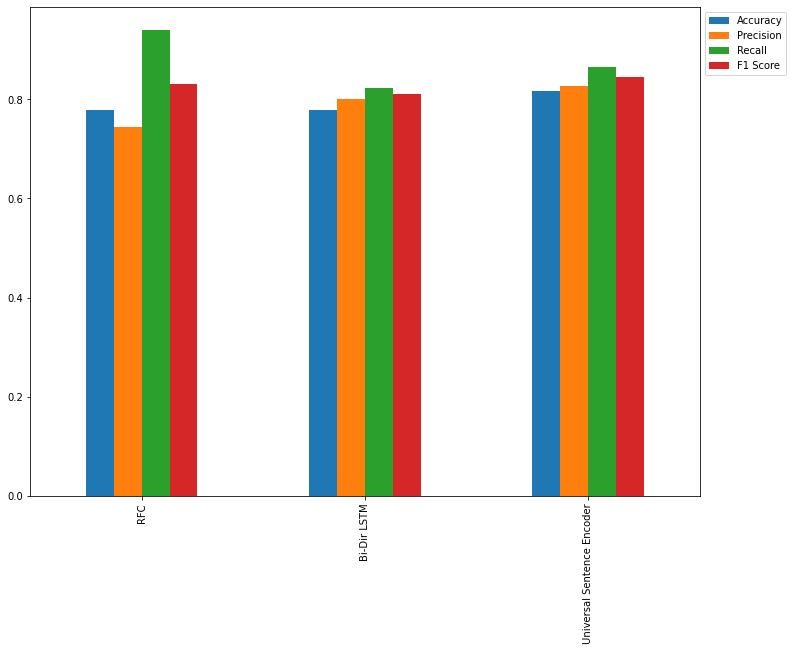

In [195]:
df_model_summary.plot(kind = 'bar' , figsize = (12,9)).legend(bbox_to_anchor = (1,1))

### 6.4 Visualing Word Vectors
___

* From earlier embedding projector , we could observed how each word is linked to each other via vectors after the tokens are parse through the embedding layers.
* From our model , we have define 128 vectors for each words.
* From the below example, we picked 9 closely related words to fakenews and 1 word related to world news.

In [231]:
word_list = ['trump' , 'articl' , 'trump' , 'black' , 'facebook' , 'inform' , 'check' , 'offic' , 'facts' , 'afghanistan']
embed_list = []
embed_list = [embedding(text_vectorizer([word]))[0][0] for word in word_list]

In [232]:
np.savetxt('embed.csv' , embed_list , delimiter=',')

In [235]:
# Sample tensor of a word vector
embed_list[0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-0.68015563, -0.1836073 ,  0.39484736,  0.15070057,  0.15845202,
       -0.51658845,  0.2887819 ,  0.57741106, -0.3007568 ,  0.09720924,
       -0.02036186,  0.6639839 ,  0.18024425, -0.6384843 ,  0.62177324,
       -0.77736694, -0.50788254,  0.11390698, -0.467032  , -0.48327976,
       -0.12054961,  0.28891927,  0.4093846 , -0.4757942 ,  0.01158564,
       -0.2148645 ,  0.27583212,  0.4399314 ,  0.3229067 ,  0.15102296,
        0.31573844, -0.09368858,  0.22483808, -0.35937104,  0.40356663,
       -0.3454503 ,  0.5650083 , -0.07634466,  0.09119768,  0.4800464 ,
       -0.45358744,  0.29066017, -0.4809847 , -0.5502586 , -0.41021594,
        0.41739368,  0.19163693, -0.13887438, -0.2792059 , -0.26617184,
       -0.11195996,  0.46076426,  0.32116845,  0.5412537 ,  0.0168842 ,
        0.19403419, -0.8346041 ,  0.4983352 , -0.22461487, -0.45823824,
        0.2452017 ,  0.15438133,  0.10800563,  0.3737477 , -0.5314714 ,
        0.137764

### Comparing word vectors across the 10 words for sample arrary
___

* We could observed that for the 1st 9 words which are closely related to each other, their vectors for certain arrays are very similiar.
* We could also observed that at the 10th row , which are not related to the 1st 9 words , often break away at certain arrays.

<img src = 'https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/images/word_embed.PNG'>

# 7.0 Conclusion and recommendations
___

In [ ]:
model_RFC.f